In [1]:
%pip install pandas numpy matplotlib torch scikit-learn openpyxl


^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------------------- ------------------ 30.7/60.4 kB 660.6 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.4 kB 495.5 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.4 kB 495.5 kB/s eta 0:00:01
     -------------------------------------- 60.4/60.4 kB 401.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/198.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/198.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/198.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/198.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/198.6 MB ? eta -:--:--
   ---------------------------------------- 0.2/198.6 MB 908.0 kB/s eta 0:03:39
   ---------------------------------------- 0.2/198.6 MB 888.4 kB/s eta 0:03:44
   ---------------------------------------- 0.3/198.6 MB 827.5 kB/s eta 0:04:00
   ----------

In [4]:
# Load your CSV file
df = pd.read_excel("LSTM_dataset.xlsx")

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set Date column as index
df.set_index('Date', inplace=True)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

In [5]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Preprocess the historical data
seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
train_size = int(len(y) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize the LSTM model
input_size = scaled_data.shape[1]  # Number of features (columns) in your input data
hidden_size = 50
num_layers = 1
output_size = scaled_data.shape[1]  # Same as input size for this task
model = LSTM(input_size, hidden_size, num_layers, output_size)

# Set training parameters
learning_rate = 0.01
num_epochs = 100

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Train the model
for epoch in range(num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.0397
Epoch [20/100], Loss: 0.0094
Epoch [30/100], Loss: 0.0026
Epoch [40/100], Loss: 0.0034
Epoch [50/100], Loss: 0.0020
Epoch [60/100], Loss: 0.0019
Epoch [70/100], Loss: 0.0017
Epoch [80/100], Loss: 0.0017
Epoch [90/100], Loss: 0.0016
Epoch [100/100], Loss: 0.0016


In [8]:
#Test Model
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0043


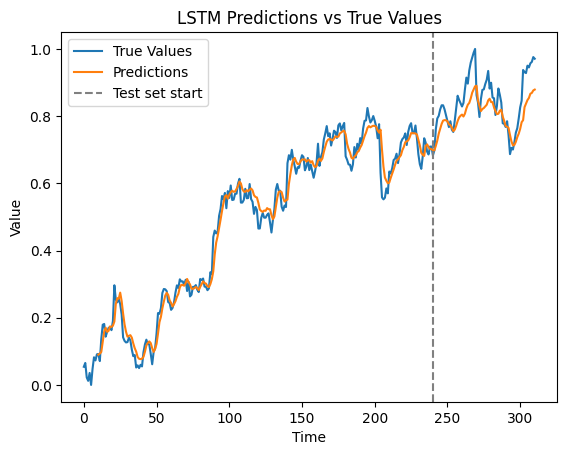

In [9]:
# Concatenate the training and test predictions
with torch.no_grad():
    train_outputs = model(X_train).squeeze().numpy()
    test_outputs = model(X_test).squeeze().numpy()
all_outputs = np.concatenate((train_outputs, test_outputs))

# Calculate the index where the test set starts
test_start_index = len(scaled_data) - len(y_test) - seq_length

# Plot the true values and the predictions
plt.plot(scaled_data[:, 0], label="True Values")  # Plotting only the first column (A) for example
plt.plot(range(seq_length, seq_length + len(all_outputs)), all_outputs[:, 0], label="Predictions")
plt.axvline(x=test_start_index, color='gray', linestyle='--', label="Test set start")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("LSTM Predictions vs True Values")
plt.show()
